# Control experiment

In [1]:
# Imports

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter

from tigramite import data_processing as pp
from tigramite import plotting as tp

import pandas as pd
import xarray as xr

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import re
import pickle

from tigramite.causal_effects import CausalEffects
from tigramite.data_processing import DataFrame

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import resample
from statsmodels.tsa.stattools import pacf

from tigramite.pcmci import PCMCI
from tigramite.plotting import plot_time_series_graph as plot_graph

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
%cd /Users/alexandrine/Library/CloudStorage/OneDrive-TechnischeUniversitätBerlin/causal_detection_of_CSD/
import functions.generate_data as gendata
import functions.shift_detection as shiftdetect
import functions.sliding_windows as sw
import functions.indicators_computation as ind
import functions.significance_testing as sgtest
import functions.data_analysis as analysis
import functions.helpers as helpers

/Users/alexandrine/Library/CloudStorage/OneDrive-TechnischeUniversitätBerlin/causal_detection_of_CSD


# Helpers

In [3]:
def compute_CE_for_all_lags(dataAMOC_det, dataGrIS_det, graphs, estimator, time_windows):
    results = {}

    # --- Graph A: AMOC only ---
    #print("Analyzing Graph A (AMOC only)")
    graph_AMOC = np.array([[['', '-->']],], dtype='<U3')
    causal_effects_AMOC = CausalEffects(
        graph_AMOC,
        graph_type='stationary_dag',
        X=[(0, -1)],
        Y=[(0, 0)],
        S=None,
        hidden_variables=None,
        verbosity=0
    )

    data_AMOC_only = dataAMOC_det.reshape(-1, 1)
    var_names_AMOC = [r'$AMOC$']

    causal_KNN_AMOC, _, _ = ind.pipeline_causalEE_weighted(
        causal_effects_AMOC,
        data_AMOC_only,
        estimator,
        data_transform=StandardScaler(),
        n_points=n_points,
        time_windows=time_windows,
        var_names=var_names_AMOC,
        edge_points_proportion=edge_points_proportion,
    )

    results["Graph A"] = causal_KNN_AMOC

    # --- Graphs for GrIS → AMOC ---
    for i, graph in enumerate(graphs):
        #print(f"Analyzing Graph {i} (GrIS → AMOC)")
        causal_effects = CausalEffects(
            graph,
            graph_type='stationary_dag',
            X=[(1, -1)],
            Y=[(1, 0)],
            S=None,
            hidden_variables=None,
            verbosity=0
        )

        data_pair = np.hstack([
            dataGrIS_det.reshape(-1, 1),
            dataAMOC_det.reshape(-1, 1)
        ])
        var_names = [r'$GrIS$', r'$AMOC$']

        causal_KNN, _, _ = ind.pipeline_causalEE_weighted(
            causal_effects,
            data_pair,
            estimator,
            data_transform=StandardScaler(),
            n_points=n_points,
            time_windows=time_windows,
            var_names=var_names,
            edge_points_proportion=edge_points_proportion,
        )

        results[f"Graph {i}"] = causal_KNN

    return results


In [4]:
def create_graph_from_results(results):
    graphs = []
    for i, (label, values) in enumerate(results.items()):
        if 'A' in label or 'AMOC' in label:
            color = 'rgb(0,153,198)'  # AMOC blue
        else:
            color = 'rgb(115,175,72)'  # GrIS green

        graphs.append({
            'label': label,
            'values': values,
            'color': color
        })
    return graphs

In [5]:
def compute_and_save_plot_data(graphs, nb_surrogates, save_path=None):

    def extract_pval(value):
        slope, _ = np.polyfit(np.arange(len(value)), value, 1)
        pval, _ = sgtest.p_value_from_fourier(value, nb_surrogates, slope)
        return slope, float(np.array(pval).flatten()[0])

    processed_graphs = []

    for i, graph in enumerate(graphs):
        central_slope, central_pval = extract_pval(graph['values'])

        processed_graph = {
            'label': graph['label'],
            'central_slope': central_slope,
            'central_pval': central_pval,
            'color': graph.get('color', f"rgb({i*40%255},{i*60%255},{i*80%255})")
        }
        processed_graphs.append(processed_graph)

    if save_path is not None:
        with open(save_path, 'wb') as f:
            pickle.dump(processed_graphs, f)
    else:
        return processed_graphs

In [6]:
def plot_precomputed_results_boxplot(processed_graphs, title='Central values and bootstrap slopes with 90% confidence intervals'):

    fig = go.Figure()

    central_vals = [g['central_slope'] for g in processed_graphs]
    central_pvals = [g['central_pval'] for g in processed_graphs]
    x_labels = [g['label'] for g in processed_graphs]
    colors = [g['color'] for g in processed_graphs]

    for i, (val, pval, color) in enumerate(zip(central_vals, central_pvals, colors)):
        if pval < 0.01:
            fig.add_trace(go.Scatter(
                x=[i], y=[val], mode='markers',
                marker=dict(symbol='circle', size=12, color=color, line=dict(width=2, color='black')),
                showlegend=False
            ))
        elif 0.01 <= pval < 0.05:
            fig.add_trace(go.Scatter(
                x=[i], y=[val], mode='markers',
                marker=dict(symbol='circle', size=12, color=color, line=dict(width=2, color='black')),
                showlegend=False
            ))
            fig.add_trace(go.Scatter(
                x=[i], y=[val], mode='markers',
                marker=dict(symbol='x', size=6, color='red'),
                showlegend=False
            ))
        else:
            fig.add_trace(go.Scatter(
                x=[i], y=[val], mode='markers',
                marker=dict(symbol='x', size=12, color=color, line=dict(width=2, color='black')),
                showlegend=False
            ))

    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='circle', size=9, color='black'),
                             name='p < 0.05'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='x', size=9, color='black'),
                             name='p ≥ 0.05'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='x', size=9, color='red'),
                             name='p ≥ 0.01'))

    fig.update_layout(
        title=title,
        xaxis=dict(tickmode='array', tickvals=list(range(len(x_labels))), ticktext=x_labels),
        yaxis=dict(title='Slope (×10³)', #tickvals=[-0.001, 0, 0.001, 0.002, 0.003, 0.004],
                   #ticktext=['-1', '0', '1', '2', '3', '4']
                   ),
        height=400,
        width=400 + 60 * (len(processed_graphs) - 3),
        template='simple_white',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
    )

    # Ligne horizontale au niveau de la première pente centrale
    fig.add_trace(go.Scatter(
        x=[0, len(processed_graphs) - 1],
        y=[central_vals[0], central_vals[0]],
        mode='lines',
        line=dict(color='rgb(0,153,198)', dash='dot'),
        opacity=0.6,
        showlegend=False
    ))

    fig.show()

# control for simulated data

In [7]:
path = '/Users/alexandrine/Library/CloudStorage/OneDrive-TechnischeUniversitätBerlin/causal_detection_of_CSD/results_causalCSD/saddle-node/methods/controlXP/'

In [10]:
base_data_LinReg = analysis.load_and_rename_files(path, 'base-linear-0.01-LinearRegression-rmvDet-1000.dat')
base_data_KNN = analysis.load_and_rename_files(path, 'base-linear-0.01-KNeighborsRegressor-rmvDet-1000.dat')
control_data_LinReg = analysis.load_and_rename_files(path, 'control_confounderIncreasAC-linear-0.01-LinearRegression-rmvDet-1000.dat')
control_data_KNN = analysis.load_and_rename_files(path, 'control_confounderIncreasAC-linear-0.01-KNeighborsRegressor-rmvDet-1000.dat')

In [12]:
# Check if the data in base_data matches control_data
for i in range(100):
    assert (base_data_KNN['base_linear_001_KNeighborsRegressor_rmvDet_1000']['data'][i]['data'][:,1]).all() == (control_data_KNN['control_confounderIncreasAC_linear_001_KNeighborsRegressor_rmvDet_1000']['data'][i]['data'][:,2]).all()

In [15]:
control_data = control_data_KNN['control_confounderIncreasAC_linear_001_KNeighborsRegressor_rmvDet_1000']
base_data = base_data_KNN['base_linear_001_KNeighborsRegressor_rmvDet_1000']

In [16]:
slopes_control = []
len_control = len(control_data['indicator'])
for i in range(len_control):
    slope, _ = np.polyfit(np.arange(len(control_data['indicator'][i])), 
                          control_data['indicator'][i], 1)
    slopes_control.append(slope)

In [17]:
slopes_base = []
for i in range(len_control):
    slope, _ = np.polyfit(np.arange(len(base_data['indicator'][i])), 
                          base_data['indicator'][i], 1)
    slopes_base.append(slope)

In [18]:
slope_differences = (np.array(slopes_control) - np.array(slopes_base))/ np.array(slopes_base) * 100

In [19]:
np.sum((slope_differences >= -2) & (slope_differences <= 2))

11

In [20]:
pvalues_control = control_data['pvalue']
pvalues_base = base_data['pvalue'][:len_control]

In [21]:
pvalue_differences = (np.array(pvalues_control) - np.array(pvalues_base))/ np.array(pvalues_base) * 100

/var/folders/lm/c2t_62cj4rg3ry50_0z2s5j00000gn/T/ipykernel_3459/3479584557.py:1: RuntimeWarning: divide by zero encountered in divide
  pvalue_differences = (np.array(pvalues_control) - np.array(pvalues_base))/ np.array(pvalues_base) * 100
/var/folders/lm/c2t_62cj4rg3ry50_0z2s5j00000gn/T/ipykernel_3459/3479584557.py:1: RuntimeWarning: invalid value encountered in divide
  pvalue_differences = (np.array(pvalues_control) - np.array(pvalues_base))/ np.array(pvalues_base) * 100


In [25]:
epsilon = 1e-10
pvalues_control = np.array(pvalues_control)
pvalues_base = np.array(pvalues_base)

safe_base = np.where(pvalues_base == 0, epsilon, pvalues_base)
pvalue_differences = (pvalues_control - pvalues_base) / safe_base * 100

In [27]:
pvalue_differences

array([-7.50000000e+01,  0.00000000e+00, -9.50000000e+01, -2.99363057e+01,
       -6.94117647e+01, -1.00000000e+02, -1.00000000e+02, -1.00000000e+02,
       -1.00000000e+02, -1.00000000e+02,  1.00000000e+09,  3.00000000e+02,
       -6.25000000e+00, -9.16666667e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -6.25000000e+01, -5.00000000e+01, -9.61904762e+01,
        1.18918919e+02, -1.00000000e+02, -1.85185185e+01,  1.06349206e+02,
       -1.00000000e+02,  1.00000000e+09, -2.53164557e+01, -1.00000000e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -5.14285714e+01,
        0.00000000e+00,  3.00000000e+02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.00000000e+02, -3.83458647e+01,  0.00000000e+00,
        3.00000000e+02, -9.64285714e+01, -8.33333333e+01, -1.00000000e+02,
       -6.53846154e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -7.64705882e+01,  1.00000000e+02, -1.00000000e+02,  0.00000000e+00,
        0.00000000e+00, -

In [26]:
fig = go.Figure()
fig.add_trace(go.Box(
    y=slope_differences,
    name='',
    marker_color='rgb(115,175,72)',
    boxpoints='all',
    jitter=0.3,
    pointpos=0,
    showlegend=False
))
fig.update_layout(
    title='Slope Differences between Control and Base Data',
    #xaxis_title='Data Type',
    yaxis_title='Slope difference (%)',
    height=500,
    width=400,
    template='simple_white'
)
fig.update_layout(
    xaxis=dict(
        range=[-0.35, 0.35],
        tickvals=[],  # optional: removes tick labels
    )
)

fig.show()

In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.arange(len(slopes_base)),
    y=slopes_base,
    mode='lines+markers',
    name='Base',
    marker=dict(color='black', size=8)
)
)

fig.add_trace(go.Scatter(
    x=np.arange(len(slopes_control)),
    y=slopes_control,
    mode='lines+markers',
    name='Control',
    marker=dict(color='rgb(115,175,72)', size=8)
)
)

fig.update_layout(
    title='Slopes of Indicators for Control and Base Data',
    xaxis_title='Realisation',
    yaxis_title='Slope',
    height=500,
    width=800,
    template='simple_white',
    legend=dict(yanchor='bottom', y=0.86, x=0.05)
)
fig.show()

In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.arange(len(slopes_base)),
    y=pvalues_base,
    mode='lines+markers',
    name='Base',
    marker=dict(color='black', size=8)
)
)
fig.add_trace(go.Scatter(
    x=np.arange(len(slopes_control)),
    y=pvalues_control,
    mode='lines+markers',
    name='Control',
    marker=dict(color='rgb(115,175,72)', size=8)
)
)
fig.add_trace(go.Scatter(x=[0,100], y=[0.05, 0.05],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='p = 0.05',
    showlegend=True))

fig.add_trace(go.Scatter(x=[0,100], y=[0.01, 0.01],
    mode='lines',
    line=dict(color='orange', width=2, dash='dash'),
    name='p = 0.01',
    showlegend=True))

fig.update_layout(
    title='pvalues of Indicators for Control and Base Data',
    xaxis_title='Realisation',
    yaxis_title='pvalue',
    height=500,
    width=800,
    template='simple_white',
    legend=dict(yanchor='bottom', y=0.75, x=0.05)

)

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(
    y=slope_differences,
    name='',
    marker_color='rgb(115,175,72)',
    boxpoints='all',
    jitter=0.3,
    pointpos=0,
    showlegend=False
))
fig.update_layout(
    title='Slope Differences between Control and Base Data',
    #xaxis_title='Data Type',
    yaxis_title='Slope Difference (%)',
    height=500,
    width=500,
    template='simple_white'
)
fig.show()

# Import data

### Melt rates and Caesar

In [7]:
# GIS, Arctic summer temperature, AMOC
file_path = "data/JJA_CWG_NU.xlsx"
JJA_CWG_NU_AMOC = pd.read_excel(file_path)
JJA_CWG_NU_AMOC = JJA_CWG_NU_AMOC[["Year", "JJA", "CWG", "NU", "AMOC_Caesar"]]

In [8]:
df_1871_2013 = JJA_CWG_NU_AMOC[JJA_CWG_NU_AMOC['Year'] >= 1871]
df_1871_2013 = df_1871_2013.iloc[::-1].reset_index(drop=True)
years_1871_2013 = list(df_1871_2013["Year"])
years_1871_2013 = np.array(years_1871_2013)
df_1871_2013 = df_1871_2013.set_index('Year')

### Salinities

In [9]:
# --- Global parameters ---
years_1900_2020 = np.arange(1900, 2020)  # data years
months = ['%02d' % m for m in range(1, 13)]
tlen = len(years_1900_2020) * 12         # total length in months
dth = 300                      # maximum depth in meters

In [10]:
sal_300 = np.load(f'data/EN422_NA_salinity_am_d300.npy')
sal_klus_300 = np.load(f'data/EN422_KLUS_salinity_am_d300.npy')

sal_500 = np.load(f'data/EN422_NA_salinity_am_d500.npy')
sal_klus_500 = np.load(f'data/EN422_KLUS_salinity_am_d500.npy')

### AMOC Ditlevsen

In [11]:
# monthly from 1870 to 2020
ditlevsen = pd.read_csv("data/AMOCdata.txt", sep=' ')

In [12]:
filtered_ditlevsen = ditlevsen[(ditlevsen['time'] >= 1871) & (ditlevsen['time'] <= 2013)].copy()
filtered_ditlevsen['year'] = filtered_ditlevsen['time'].astype(int)
AMOC_ditlevsen_yearly_1871_2013 = filtered_ditlevsen.groupby('year')['AMOC2'].mean()
AMOC_ditlevsen_yearly_1871_2013.name = 'AMOC'

### Preprocessing

In [13]:
sigma = 30

AMOC_Caesar = df_1871_2013["AMOC_Caesar"].values
AMOC_Caesar_det = AMOC_Caesar - gaussian_filter(AMOC_Caesar, sigma=sigma)
AMOC_Ditlevsen = AMOC_ditlevsen_yearly_1871_2013.values
AMOC_Ditlevsen_det = AMOC_Ditlevsen - gaussian_filter(AMOC_Ditlevsen, sigma=sigma)

CWG = df_1871_2013["CWG"].values
CWG_det = CWG - gaussian_filter(CWG, sigma=sigma)
CWG_log = np.log(CWG + np.abs(CWG.min()) + 1)
CWG_log_det = CWG_log - gaussian_filter(CWG_log, sigma=sigma)

NU = df_1871_2013["NU"].values
NU_det = NU - gaussian_filter(NU, sigma=sigma)
NU_log = np.log(NU + np.abs(NU.min()) + 1)
NU_log_det = NU_log - gaussian_filter(NU_log, sigma=sigma)

sal_300_det = sal_300 - gaussian_filter(sal_300, sigma=sigma)
sal_klus_300_det = sal_klus_300 - gaussian_filter(sal_klus_300, sigma=sigma)
sal_500_det = sal_500 - gaussian_filter(sal_500, sigma=sigma)
sal_klus_500_det = sal_klus_500 - gaussian_filter(sal_klus_500, sigma=sigma)

# Experiment

In [14]:
n_points = 150
edge_points_proportion = 0.05

In [15]:
graphsCE = [
    np.array([[['', '-->'], ['-->', '']],
            [['<--', ''], ['', '-->']],], dtype='<U3'), 

    np.array([[['', '-->'], ['', '-->']],
    [['', ''], ['', '-->']],], dtype='<U3'),

    np.array([[['', '-->', ''], ['', '', '-->']],
    [['', '', ''], ['', '-->', '']],], dtype='<U3'),

    np.array([[['', '-->', '', ''], ['', '', '', '-->']],
    [['', '', '', ''], ['', '-->', '', '']]], dtype='<U3'),

    np.array([[['', '-->', '', '', ''], ['', '', '', '', '-->']],
                [['', '', '', '', ''], ['', '-->', '', '', '']]], dtype='<U3'),

    np.array([[['', '-->', '', '', '', ''], ['', '', '', '', '', '-->']],
                [['', '', '', '', '', ''], ['', '-->', '', '', '', '']]], dtype='<U3'),

    np.array([[['', '-->', '', '', '', '', ''], ['', '', '', '', '', '', '-->']],
                        [['', '', '', '', '', '', ''], ['', '-->', '', '', '', '', '']]], dtype='<U3'),
    ]

In [16]:
window_length = 70
window_step = 1

In [17]:
def compute_results_graphs(AMOC_proxy, GrIS_proxy, estimator):
    if AMOC_proxy == 'Caesar':
        dataAMOC = AMOC_Caesar_det
    elif AMOC_proxy == 'Ditlevsen':
        dataAMOC = AMOC_Ditlevsen_det
    elif AMOC_proxy == 'sal_300':
        dataAMOC = -sal_300_det[:-6]
    elif AMOC_proxy == 'sal_klus_300':
        dataAMOC = -sal_klus_300_det[:-6]
    elif AMOC_proxy == 'sal_500':
        dataAMOC = -sal_500_det[:-6]
    elif AMOC_proxy == 'sal_klus_500':
        dataAMOC = -sal_klus_500_det[:-6]

    if isinstance(GrIS_proxy, str):
        if GrIS_proxy == 'CWG':
            dataGrIS = CWG_log_det
        elif GrIS_proxy == 'NU':
            dataGrIS = NU_log_det
        else:
            raise ValueError(f"Unknown GrIS_proxy string: {GrIS_proxy}")
    else:
        dataGrIS = GrIS_proxy


    if AMOC_proxy == 'sal_300' or AMOC_proxy == 'sal_klus_300' or AMOC_proxy == 'sal_500' or AMOC_proxy == 'sal_klus_500':
        dataGrIS = dataGrIS[29:]

    t_len = len(dataGrIS)
    time_windows, _ = sw.get_centered_sliding_windows(window_length, window_step, t_len)

    results = compute_CE_for_all_lags(dataAMOC, dataGrIS, graphsCE, estimator, time_windows)
    results_graphs = create_graph_from_results(results)
    results_graphs = compute_and_save_plot_data(results_graphs, nb_surrogates=10000, save_path=None)

    return results_graphs

In [18]:
AMOC_proxies = ['Caesar', #'Ditlevsen', 
                'sal_300', 'sal_klus_300',
                #'sal_500', 'sal_klus_500'
                ]
GIS_proxies = ['CWG', 'NU']

# Experiments with GIS data

In [19]:
# results_graphs_dict_real_data = {}

# for proxy in AMOC_proxies:
#     for proxy2 in GIS_proxies:
#         print(f"Computing results for AMOC proxy: {proxy}, GrIS proxy: {proxy2}")
        
#         results_graphs = compute_results_graphs(proxy, proxy2, LinearRegression())
        
#         key = f"{proxy}_{proxy2}"
#         results_graphs_dict_real_data[key] = results_graphs
        
        #plot_precomputed_results_boxplot(results_graphs, title=f'{proxy} and {proxy2}')
#pickle.dump(results_graphs_dict_real_data, open('results_graphs_dict_real_data.pickle', 'wb'))

In [20]:
# assuming lag 1 influence of AMOC on AMOC
graph =  np.array([[['', '-->']],], dtype='<U3')

X = [(0,-1)]
Y = [(0,0)]

causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)

time_windows, center_points = sw.get_centered_sliding_windows(window_length=70, window_step=1, t_len=len(sal_klus_300))

causal_KNN_sal_klus_300, _, _ = ind.pipeline_causalEE_weighted(
    causal_effects, -sal_klus_300_det.reshape(-1, 1), KNeighborsRegressor(), data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$AMOC$'], edge_points_proportion=0.15)

In [21]:
AC_sal_klus_300 = ind.regular_autocorrelation(
    data=-sal_klus_300, time_windows=time_windows, lag=1, detrend=True)

In [22]:
slopeKNN300, interceptKNN300 = np.polyfit(np.arange(len(causal_KNN_sal_klus_300)), causal_KNN_sal_klus_300, 1)
pvalKNN300, _ = sgtest.p_value_from_fourier(causal_KNN_sal_klus_300, 10000, slopeKNN300)

slopeAC300, interceptAC300 = np.polyfit(np.arange(len(AC_sal_klus_300)), AC_sal_klus_300, 1)
pvalAC300, _ = sgtest.p_value_from_fourier(AC_sal_klus_300, 10000, slopeAC300)

In [23]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=years_1900_2020+window_length//2, y=causal_KNN_sal_klus_300,
    mode='lines', name='sal_klus_300 causal KNN',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(x=years_1900_2020+window_length//2, y=slopeKNN300 * np.arange(len(causal_KNN_sal_klus_300)) + interceptKNN300, mode='lines', name=f'pv: {pvalKNN300:.2f}', line=dict(color='blue', dash='dash')))


fig.add_trace(go.Scatter(
    x=years_1900_2020+window_length//2, y=AC_sal_klus_300,
    mode='lines', name='sal_klus_300 AC1',
    line=dict(color='orange')
))
fig.add_trace(go.Scatter(x=years_1900_2020+window_length//2, y=slopeAC300 * np.arange(len(AC_sal_klus_300)) + interceptAC300, mode='lines', name=f'pv: {pvalAC300:.2f}', line=dict(color='orange', dash='dash')))


fig.update_layout(
    xaxis_range=[1900, 2020],
    xaxis_title='Time (years)',
    yaxis_title='Indicator',
    height=400, width=700,
    template='simple_white'
)

fig.show()

# Control experiments

In [24]:
window_length = 70

In [1]:
time_windows, _ = sw.get_centered_sliding_windows(window_length, window_step, len(CWG_log_det))

NameError: name 'sw' is not defined

In [26]:
AC_CWG = ind.regular_autocorrelation(CWG_log_det, time_windows, lag=1, detrend=True)
AC_NU = ind.regular_autocorrelation(NU_log_det, time_windows, lag=1, detrend=True)


fig = go.Figure()
fig.add_trace(go.Scatter(x=years_1871_2013+window_length//2, y=AC_CWG, mode='lines', name='AC CWG'))
fig.add_trace(go.Scatter(x=years_1871_2013+window_length//2, y=AC_NU, mode='lines', name='AC NU'))
fig.update_layout(
    xaxis_range=[1871, 2013],
    xaxis_title='Time (years)',
    yaxis_title='Autocorrelation (lag-1)',
    template='simple_white',
    height=400, width=700
)
fig.show()

In [27]:
len(CWG_log_det)

143

In [28]:
# Step 1: Define your target autocorrelation profile
acf_start = 0.1  # AC(ref_series)[0]
acf_end = 0.35    # AC(ref_series)[-1]
t_len = 143

# Create a linearly increasing AR(1) coefficient profile
betas_full = np.linspace(acf_start, acf_end, t_len)

# Clip to ensure AR(1) stability
#betas_full = np.clip(betas_full, -0.99, 0.99)

# Step 2: Simulate AR(1) with time-varying coefficients
def simulate_nonstationary_AR1(betas, sigma=0.3, seed=None):
    rng = np.random.default_rng(seed)
    epsilon = rng.normal(0, sigma, size=len(betas))
    X = np.zeros(len(betas))
    X[0] = epsilon[0]
    for t in range(1, len(betas)):
        X[t] = betas[t] * X[t-1] + epsilon[t]
    return X

sim_series = simulate_nonstationary_AR1(betas_full, sigma=0.3, seed=42)

In [29]:
AC_sim_series = ind.regular_autocorrelation(sim_series, time_windows, lag=1, detrend=True)

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=AC_CWG, mode='lines', name='Reference time series'))
fig.add_trace(go.Scatter(y=AC_sim_series, mode='lines', name='Simulation'))
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Autocorrelation (lag-1)",
    height=400, width=700,
    template='simple_white'
)
fig.show()

In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=CWG_log_det, mode='lines', name='CWG log det'))
fig.add_trace(go.Scatter(y=sim_series, mode='lines', name='Simulated series'))
fig.update_layout(
    xaxis_title='Time', yaxis_title='Value',
    template='simple_white', height=400, width=700
)
fig.show()

In [ ]:
# results_graphs_dict_simulated_data = {}

# for proxy in AMOC_proxies:
#     syndata = sim_series
#     print(f"Computing results for AMOC proxy: {proxy}, GrIS proxy: synthetic_data")
#     results_graphs = compute_results_graphs(proxy, syndata, LinearRegression())
#     key = f"{proxy}_synthetic_data"
#     results_graphs_dict_simulated_data[key] = results_graphs

#     plot_precomputed_results_boxplot(results_graphs, title=f'Control xp: {proxy} and synthetic data')

In [33]:
def plot_precomputed_results_boxplot_from_dicts(
    key,
    results_real_dict,
    results_control_dict,
    title=None
):
    processed_graphs = results_real_dict[key]
    
    if "Caesar" in key:
        control_key = "Caesar_synthetic_data"
    elif "Ditlevsen" in key:
        control_key = "Ditlevsen_synthetic_data"
    elif "sal_300" in key:
        control_key = "sal_300_synthetic_data"
    elif "sal_klus_300" in key:
        control_key = "sal_klus_300_synthetic_data"
    elif "sal_500" in key:
        control_key = "sal_500_synthetic_data"
    elif "sal_klus_500" in key:
        control_key = "sal_klus_500_synthetic_data"
    else:
        raise ValueError(f"No key {key}")
    
    results_control_xp = results_control_dict.get(control_key, None)

    fig = go.Figure()

    central_vals = [g['central_slope'] for g in processed_graphs]
    central_pvals = [g['central_pval'] for g in processed_graphs]
    x_labels = [g['label'] for g in processed_graphs]
    colors = [g['color'] for g in processed_graphs]

    for i, (val, pval, color) in enumerate(zip(central_vals, central_pvals, colors)):
        if pval < 0.01:
            fig.add_trace(go.Scatter(
                x=[i], y=[val], mode='markers',
                marker=dict(symbol='circle', size=12, color=color, line=dict(width=2, color='black')),
                showlegend=False
            ))
        elif 0.01 <= pval < 0.05:
            fig.add_trace(go.Scatter(
                x=[i], y=[val], mode='markers',
                marker=dict(symbol='circle', size=12, color=color, line=dict(width=2, color='black')),
                showlegend=False
            ))
            fig.add_trace(go.Scatter(
                x=[i], y=[val], mode='markers',
                marker=dict(symbol='x', size=6, color='red'),
                showlegend=False
            ))
        else:
            fig.add_trace(go.Scatter(
                x=[i], y=[val], mode='markers',
                marker=dict(symbol='x', size=12, color=color, line=dict(width=2, color='black')),
                showlegend=False
            ))

    # Control results
    if results_control_xp is not None:
        control_vals = [g['central_slope'] for g in results_control_xp]
        control_pvals = [g['central_pval'] for g in results_control_xp]

        for i, (val, pval) in enumerate(zip(control_vals, control_pvals)):
            if i == 0:
                continue  # Ignorer le 1er point
            if pval < 0.01:
                fig.add_trace(go.Scatter(
                    x=[i], y=[val], mode='markers',
                    marker=dict(symbol='circle', size=12, color='lightgrey'),
                    showlegend=False
                ))
            elif 0.01 <= pval < 0.05:
                fig.add_trace(go.Scatter(
                    x=[i], y=[val], mode='markers',
                    marker=dict(symbol='circle', size=12, color='lightgrey'),
                    showlegend=False
                ))
                fig.add_trace(go.Scatter(
                    x=[i], y=[val], mode='markers',
                    marker=dict(symbol='x', size=6, color='red'),
                    showlegend=False
                ))
            else:
                fig.add_trace(go.Scatter(
                    x=[i], y=[val], mode='markers',
                    marker=dict(symbol='x', size=12, color='lightgrey'),
                    showlegend=False
                ))

    # Legend for p-values
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='circle', size=9, color='black'),
                             name='p < 0.05'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='x', size=9, color='black'),
                             name='p ≥ 0.05'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='x', size=9, color='red'),
                             name='p ≥ 0.01'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='square', size=9, color='lightgrey'),
                             name='Control'))

    fig.update_layout(
        title=title or f"Results for {key.replace('_', ' and ')}",
        xaxis=dict(tickmode='array', tickvals=list(range(len(x_labels))), ticktext=x_labels),
        yaxis=dict(title='Slope (×10³)', tickvals=[-0.001, 0, 0.001, 0.002, 0.003, 0.004],
                   ticktext=['-1', '0', '1', '2', '3', '4']),
        height=500,
        width=400 + 60 * (len(processed_graphs) - 3),
        template='simple_white',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
    )

    fig.add_trace(go.Scatter(
        x=[0, len(processed_graphs) - 1],
        y=[central_vals[0], central_vals[0]],
        mode='lines',
        line=dict(color='rgb(0,153,198)', dash='dot'),
        opacity=0.6,
        showlegend=False
    ))

    fig.show()


In [35]:
# with open('results_graphs_dict_real_data.pickle', 'rb') as f:
#     results_graphs_dict_real_data = pickle.load(f)

# with open('results_graphs_dict_simulated_data.pickle', 'rb') as f:
#     results_graphs_dict_simulated_data = pickle.load(f)

In [36]:
# for key in results_graphs_dict_real_data:
#     plot_precomputed_results_boxplot_from_dicts(
#         key,
#         results_real_dict=results_graphs_dict_real_data,
#         results_control_dict=results_graphs_dict_simulated_data,
#         title=f"{key}"
#     )

In [37]:
# PB: changes the value and the significance even when no causal link !!!!

# All simulated

In [38]:
def generate_time_series(t_len, sigma_Y, sigma_X=0, seed=0, model='base', s=0.02, return_noise=True, bif_type='pitchfork', X_power=1, gamma=1, ksi=None):
    """
    Generate a time series based on the specified model type.

    Parameters:
    t_len (int): Length of the time series.
    sigma_Y (float): Standard deviation for the Y noise.
    seed (int): Random seed for reproducibility.
    model (str): Type of the model ('base', 'confounderDecreasAC', 
                                      'confounderIncreasAC', 'falseAlarm').
    return_noise (bool): Whether to return the noise as well.
    bif_type (str): Bifurcation type ('pitchfork', 'saddle-node').

    Returns:
    np.ndarray: Generated time series data.
    """
    # Initialize random generator
    random_state = np.random.default_rng(seed=seed)
    
    # Generate base random data
    dataR = random_state.normal(0, 0, size=(t_len, 1))
    dataY = random_state.normal(0, sigma_Y, size=(t_len, 1))

    # parameters
    h = 0.01  # time step
    initial_r = -1
    s = s if model != 'falseAlarm' else 0.0

    
    if model == 'base':
        data = np.hstack((dataR, dataY))

        # Initial conditions
        data[0, 0] = initial_r
        if bif_type == 'pitchfork':
            data[0, 1] = 0
        if bif_type=='saddle-node':
            data[0, 1] = 1.325

        for t in range(1, t_len):
            data[t, 0] += h * s + data[t-1, 0]

            if bif_type == 'pitchfork':
                data[t, 1] += data[t-1, 1] + h * (data[t-1, 0] * data[t-1, 1] - data[t-1, 1]**3)
            
            if bif_type == 'saddle-node':
                data[t, 1] += data[t-1, 1] + h * (data[t-1, 1] - data[t-1, 1]**3 - data[t-1, 0])

    elif model == 'confounderDecreasAC' or model == 'confounderIncreasAC' or model == 'falseAlarm':
        if bif_type == 'pitchfork':
            dataX = random_state.normal(0, sigma_X, size=(t_len, 1))
        elif bif_type == 'saddle-node':
            dataX = random_state.normal(0, sigma_X, size=(t_len, 1))
        data = np.hstack((dataR, dataX, dataY))

        if model == 'confounderDecreasAC':
            beta_0 = 0.9
            beta_middle = 0.1
            k = (beta_middle - beta_0) / (t_len // 2)

        elif model == 'confounderIncreasAC' or model == 'falseAlarm':
            beta_0 = 0.1
            beta_final = 0.4
            k = (beta_final - beta_0) / t_len

        # Initial conditions
        data[0, 0] = initial_r
        data[0, 1] = 0
        if bif_type == 'pitchfork':
            data[0, 2] = 0
        if bif_type=='saddle-node':
            data[0, 2] = 1.325

        for t in range(1, t_len):
            data[t, 0] += h * s + data[t-1, 0]

            if model == 'confounderDecreasAC':
                beta_t = max(0, beta_0 + k * t)
                data[t, 1] += beta_t * data[t-1, 1]
    
            elif model == 'confounderIncreasAC' or model == 'falseAlarm':
                beta_t = beta_0 + k * t
                data[t, 1] += beta_t * data[t-1, 1]

            if bif_type == 'pitchfork':
                data[t, 2] += data[t-1, 2] + h * (data[t-1, 0] * data[t-1, 2] - data[t-1, 2]**3 + gamma * data[t-1, 1]**X_power)
                       
            if bif_type == 'saddle-node':
                if X_power == 2:
                    if model == 'confounderDecreasAC':
                        gamma = 35
                    if model == 'confounderIncreasAC':
                        gamma = 10
                    if model == 'falseAlarm':
                        gamma = 10

                if ksi==None:
                    data[t, 2] += data[t-1, 2] + h * (data[t-1, 2] - data[t-1, 2]**3 - data[t-1, 0] + gamma * data[t-1, 1]**X_power)
                else:
                    data[t, 2] += data[t-1, 2] + h * (data[t-1, 2] - data[t-1, 2]**3 - data[t-1, 0] + gamma * np.exp(-ksi * data[t-1, 1]**X_power) * data[t-1, 1])

    if not return_noise:
        return {'data': data}
    else:
        if model == 'base':
            noise = dataY.flatten()
        else:
            noise = dataY.flatten() + data[:, 1]
        return {'data': data, 'noise': noise}

## independent X and Y

In [71]:
from collections import defaultdict

def plot_all_realizations_with_significance(processed_graphs_list, title='Bootstrap slopes with 90% confidence intervals'):
    fig = go.Figure()

    # processed_graphs_list: list of lists of dicts (one list per seed or bootstrap)
    grouped_slopes = defaultdict(list)
    grouped_pvals = defaultdict(list)
    grouped_colors = {}

    for graphs in processed_graphs_list:
        for g in graphs:
            label = g['label']
            grouped_slopes[label].append(g['central_slope'])
            grouped_pvals[label].append(g['central_pval'])
            grouped_colors[label] = g['color']

    x_labels = list(grouped_slopes.keys())

    for i, label in enumerate(x_labels):
        slopes = grouped_slopes[label]
        pvals = grouped_pvals[label]
        color = grouped_colors[label]

        # Boxplot for all realizations
        fig.add_trace(go.Box(
            y=slopes,
            x=[label] * len(slopes),
            marker_color=color,
            name=label,
            boxpoints=False,  # no outliers shown automatically
            showlegend=False
        ))

        # Add each realization as a marker with p-value-dependent symbol
        for s, p in zip(slopes, pvals):
            if p < 0.01:
                fig.add_trace(go.Scatter(
                    x=[label], y=[s], mode='markers',
                    marker=dict(symbol='circle', size=8, color=color, opacity=0.8),
                    showlegend=False
                ))
            elif 0.01 <= p < 0.05:
                fig.add_trace(go.Scatter(
                    x=[label], y=[s], mode='markers',
                    marker=dict(symbol='x', size=8, color=color, opacity=0.8),
                    showlegend=False
                ))
            else:
                fig.add_trace(go.Scatter(
                    x=[label], y=[s], mode='markers',
                    marker=dict(symbol='x', size=8, color='red', opacity=0.8),
                    showlegend=False
                ))

    # Legend markers
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='circle', size=9, color=color),
                             name='p < 0.05'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='x', size=9, color=color),
                             name='0.05 > p ≥ 0.01'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='x', size=9, color='red'),
                             name='p > 0.05'))

    fig.update_layout(
        title=title,
        xaxis=dict(title='Lag', tickmode='array', tickvals=x_labels, ticktext=x_labels),
        yaxis=dict(title='Slope' 
                   #(×10³)'
                   ),
        height=500,
        width=500 + 60 * (len(x_labels) - 3),
        template='simple_white',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
    )

    # Add dotted horizontal reference line from graph A
    if 'Graph A' in grouped_slopes:
        reference_val = sum(grouped_slopes['Graph A']) / len(grouped_slopes['Graph A'])
        fig.add_trace(go.Scatter(
            x=[x_labels[0], x_labels[-1]],
            y=[reference_val, reference_val],
            mode='lines',
            line=dict(color='rgb(0,153,198)', dash='dot'),
            opacity=0.6,
            showlegend=False
        ))
    fig.show()

In [98]:
t_len = 120

In [99]:
data_base = generate_time_series(t_len=t_len, sigma_Y = 0.01, sigma_X=0, seed = 5, model = 'base', bif_type='saddle-node', s=0.5, return_noise=True, X_power = 1)
dataY_base = data_base['data'][:, 1]

In [100]:
dataX_list = []
for i in range(100):
    dataX = generate_time_series(t_len=t_len, sigma_Y = 0.0, sigma_X=0.01, seed = i, model = 'confounderIncreasAC', bif_type='saddle-node', s=0, return_noise=True, X_power = 1)['data'][:, 1]
    dataX_list.append(dataX)

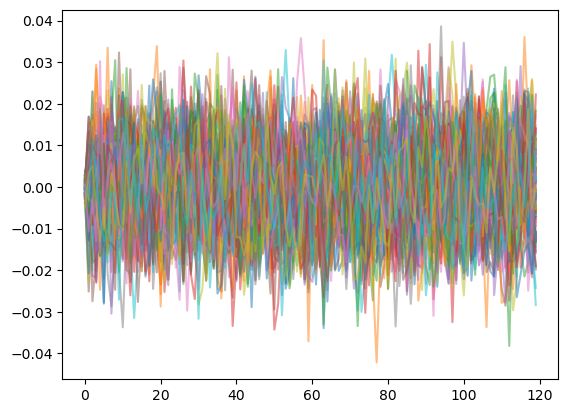

In [101]:
sigma = 30
for i in range(len(dataX_list)):
    dataX_list[i] = dataX_list[i] - gaussian_filter(dataX_list[i], sigma=sigma)
    plt.plot(dataX_list[i], label=f'Simulation {i+1} (filtered)', alpha=0.5)

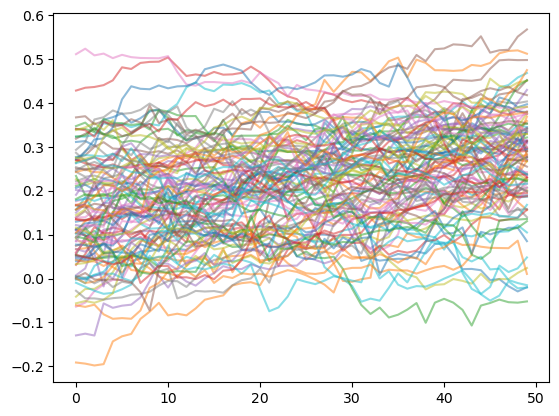

In [102]:
for i in range(len(dataX_list)):
    ac = ind.regular_autocorrelation(dataX_list[i], time_windows, lag=1, detrend=True)
    plt.plot(ac, label=f'AC Simulation {i+1}', alpha=0.5)

In [103]:
dataX_ex = dataX_list[1]

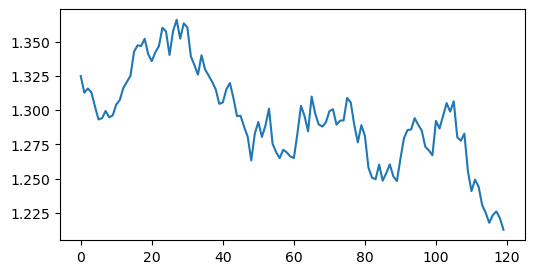

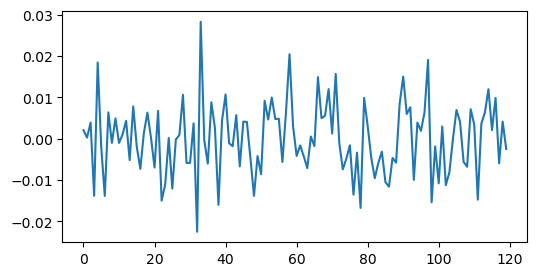

In [104]:
plt.figure(figsize=(6, 3))
plt.plot(dataY_base, label='Y base')
plt.show()
plt.figure(figsize=(6, 3))
plt.plot(dataX_ex, label='X else')
plt.show()

In [105]:
time_windows, _ = sw.get_centered_sliding_windows(70, window_step, t_len)

In [106]:
ACY = ind.regular_autocorrelation(dataY_base, time_windows, lag=1, detrend=True)
ACX = ind.regular_autocorrelation(dataX_ex, time_windows, lag=1, detrend=True)

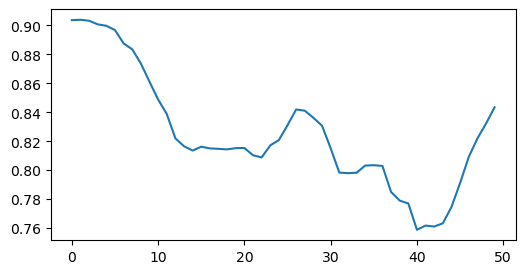

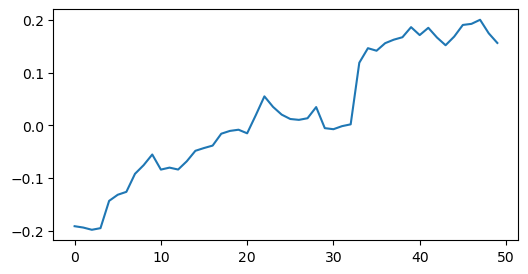

In [107]:
plt.figure(figsize=(6, 3))
plt.plot(ACY, label='AC Y')
plt.show()
plt.figure(figsize=(6, 3))
plt.plot(ACX, label='AC X')
plt.show()

In [109]:
# time_windows, _ = sw.get_centered_sliding_windows(window_length, window_step, t_len)

# results_indpXY = []
# for i in range(len(dataX_list)):
#     results = compute_CE_for_all_lags(dataY_base, dataX_list[i], graphsCE, KNeighborsRegressor(), time_windows)
#     results_graphs = create_graph_from_results(results)
#     results_graphs = compute_and_save_plot_data(results_graphs, nb_surrogates=10000, save_path=None)
#     results_indpXY.append(results_graphs)

# pickle.dump(results_indpXY, open('results_indpXY_100X_KNN.pickle', 'wb'))

In [110]:
with open('results_indpXY_100X_KNN.pickle', 'rb') as f:
    results_indpXY_KNN = pickle.load(f)

with open('results_indpXY_100X_Linreg.pickle', 'rb') as f:
    results_indpXY_Linreg = pickle.load(f)

In [111]:
plot_all_realizations_with_significance(results_indpXY_KNN, title='Independent dataX and dataY (100 realizations, KNN)')

In [112]:
plot_all_realizations_with_significance(results_indpXY_Linreg, title='Independent dataX and dataY (100 realizations, Linreg)')

## same with salinity as Y

In [64]:
t_len = len(sal_klus_300_det)

In [129]:
data_dict = gendata.generate_ts_with_detected_shift(t_len=t_len, model='base', sigma_Y=0.01, sigma_X = 0.01, threshold=0.8, bif_shift=200, return_noise=True, bif_type='saddle-node', X_power=1, seed=1)

/Users/alexandrine/Library/CloudStorage/OneDrive-TechnischeUniversitätBerlin/causal_detection_of_CSD/functions/shift_detection.py:61: RuntimeWarning:

invalid value encountered in divide

/Users/alexandrine/Library/CloudStorage/OneDrive-TechnischeUniversitätBerlin/causal_detection_of_CSD/functions/shift_detection.py:62: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/envs/tigramite_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/opt/anaconda3/envs/tigramite_env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars



In [146]:
data_dict = gendata.generate_ts_with_detected_shift(t_len=t_len, model='confounderIncreasAC', sigma_Y=0.01, sigma_X=0, threshold=0.8, bif_shift=200, return_noise=True, bif_type='saddle-node', X_power=1, seed=1)

In [147]:
data_dict['data'][:,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [148]:
dataX = gendata.generate_time_series(t_len=t_len, sigma_Y = 0.0, sigma_X=0.01, seed = 1, model = 'confounderIncreasAC', bif_type='saddle-node', return_noise=True, X_power = 1)['data'][:, 1]
data_dict['data'][:,1] = dataX

In [149]:
data_dict['data']

array([[-1.00000000e+00,  0.00000000e+00,  1.32500000e+00],
       [-9.99800000e-01, -1.78470431e-03,  1.30974111e+00],
       [-9.99600000e-01,  1.82397352e-03,  1.28570664e+00],
       [-9.99400000e-01, -1.58386038e-02,  1.29347523e+00],
       [-9.99200000e-01,  1.61160780e-02,  1.32024211e+00],
       [-9.99000000e-01, -3.87777574e-03,  1.31041495e+00],
       [-9.98800000e-01, -1.59394817e-02,  1.29849986e+00],
       [-9.98600000e-01,  3.85063124e-03,  1.30546851e+00],
       [-9.98400000e-01, -2.95761118e-03,  1.29785356e+00],
       [-9.98200000e-01,  2.77536707e-03,  1.29389449e+00],
       [-9.98000000e-01, -2.93352313e-03,  1.29167236e+00],
       [-9.97800000e-01, -1.10588095e-03,  1.29833861e+00],
       [-9.97600000e-01,  2.25866987e-03,  1.29536110e+00],
       [-9.97400000e-01, -7.04491046e-03,  1.29933389e+00],
       [-9.97200000e-01,  5.42537994e-03,  1.29859965e+00],
       [-9.97000000e-01, -3.61392500e-03,  1.29121186e+00],
       [-9.96800000e-01, -9.44374928e-03

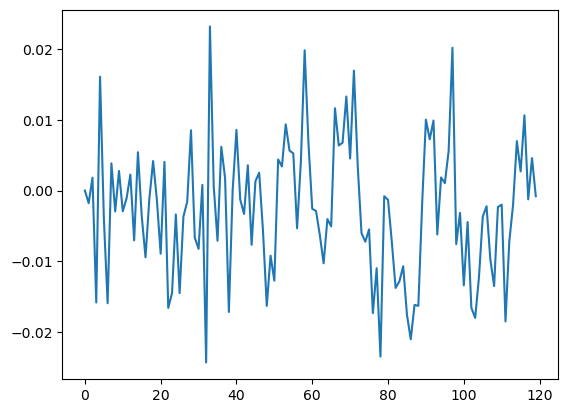

In [125]:
plt.plot(data_dict['data'][:,1])

In [65]:
dataX_list = []
for i in range(100):
    dataX = generate_time_series(t_len=t_len, sigma_Y = 0.0, sigma_X=0.01, seed = i, model = 'confounderIncreasAC', bif_type='saddle-node', s=0, return_noise=True, X_power = 1)['data'][:, 1]
    dataX_list.append(dataX)

In [66]:
# time_windows, _ = sw.get_centered_sliding_windows(window_length, window_step, t_len)

# results_indpXsalinity = []
# for i in range(len(dataX_list)):
#     results = compute_CE_for_all_lags(sal_klus_300_det, dataX_list[i], graphsCE, LinearRegression(), time_windows)
#     results_graphs = create_graph_from_results(results)
#     results_graphs = compute_and_save_plot_data(results_graphs, nb_surrogates=10000, save_path=None)
#     results_indpXsalinity.append(results_graphs)

# pickle.dump(results_indpXsalinity, open('results_indpXsalinity_100X_Linreg.pickle', 'wb'))

In [67]:
with open('results_indpXsalinity_100X_Linreg.pickle', 'rb') as f:
    results_indpXsalinity_Linreg = pickle.load(f)

with open('results_indpXsalinity_100X_KNN.pickle', 'rb') as f:
    results_indpXsalinity_KNN = pickle.load(f)

In [68]:
plot_all_realizations_with_significance(results_indpXsalinity_Linreg, title='Independent dataX and salinity (100 realizations, LinReg)')

In [69]:
plot_all_realizations_with_significance(results_indpXsalinity_KNN, title='Independent dataX and salinity (100 realizations, KNN)')